In [1]:
using Base.Threads
using ProgressMeter
using Plots
nthreads()

12

In [2]:
function f(x, p)
   r, k = p
   a, mu, d = 5.0, 0.5, 0.2
   x1new = x[1]*exp(r*(1-x[1]/k)-x[2]/(a+x[1]^2))
   x2new = x[2]*exp(mu*x[1]/(a+x[1]^2)-d)
   x1new, x2new
end

f (generic function with 1 method)

In [3]:
function traj2d!(tr1, tr2, f, p, x0, lentr, nskips)
    x = x0
    for _ in 1:nskips
        x = f(x, p)
    end
    @inbounds tr1[1], tr2[1] = x
    for i in 1:lentr
        @inbounds tr1[i+1], tr2[i+1] = f((tr1[i], tr2[i]), p)
    end
    tr1, tr2
end

traj2d! (generic function with 1 method)

In [4]:
tr1, tr2 = traj2d!(zeros(Int, 11), zeros(Int, 11), ((a, b), p) -> (b, a+b), nothing, (0, 1), 10, 10)
@show tr1 tr2;

tr1 = [55, 89, 144, 233, 377, 610, 987, 1597, 2584, 4181, 6765]
tr2 = [89, 144, 233, 377, 610, 987, 1597, 2584, 4181, 6765, 10946]


In [5]:
function findperiod(x; tol=1e-3)
    @inbounds for k in 2:length(x)
        if abs(x[k] - x[1]) ≤ tol
            all(j -> abs(x[j] - x[j-k+1]) ≤ tol, k:length(x)) && return k - 1
        end
    end 
    return length(x)
end

findperiod (generic function with 1 method)

In [6]:
x = @. sinpi(0:0.1:10) + 1e-4randn()
findperiod(x)

20

In [7]:
function calcperiod2d!(tr1, tr2, f, p, x0, lentr, nskips; tol=1e-3)
    traj2d!(tr1, tr2, f, p, x0, lentr, nskips)
    findperiod(tr1; tol)
end

calcperiod2d! (generic function with 1 method)

In [8]:
using BenchmarkTools
@btime calcperiod2d!($(zeros(2001)), $(zeros(2001)), f, (2.6, 4.0), (0.4, 0.5), 2000, 50000; tol=1e-3)

  4.218 ms (0 allocations: 0 bytes)


4

Progress: 100%|█████████████████████████████████████████| Time: 0:00:23mmm


 23.958859 seconds (1.55 M allocations: 89.502 MiB, 0.06% gc time, 3.12% compilation time)


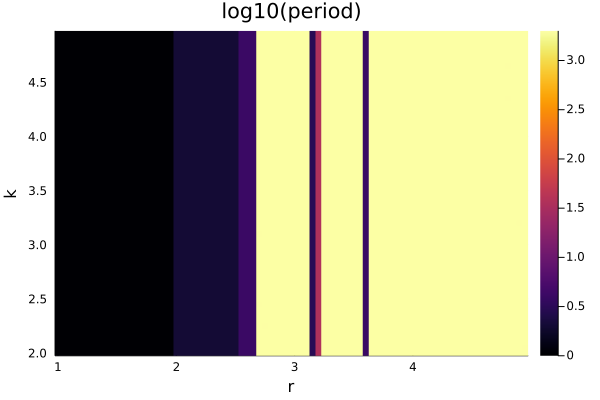

In [9]:
function calcperiod2d(f; lentr = 2000, nskips = 50000, x0 = (0.4, 0.5),
        r = (1:0.05:5)[1:end-1], k = (2:0.05:5)[1:end-1], tol=1e-3
    )
    tr1 = Vector{Float64}(undef, lentr+1)
    tr2 = Vector{Float64}(undef, lentr+1)
    period = Matrix{Int}(undef, length(r), length(k))
    prog = Progress(length(r)*length(k))
    for j in eachindex(k)
        for i in eachindex(r)
            @inbounds period[i, j] = calcperiod2d!(tr1, tr2, f, (r[i], k[j]), x0, lentr, nskips; tol)
            next!(prog)
        end
    end
    period, r, k
end

period, r, k = @time calcperiod2d(f)
heatmap(r, k, log10.(period'); xlabel="r", ylabel="k", title="log10(period)")

  3.066457 seconds (407.57 k allocations: 26.322 MiB, 0.31% gc time, 3.16% compilation time)
  3.000974 seconds (112 allocations: 424.203 KiB)
  2.948457 seconds (112 allocations: 424.203 KiB)


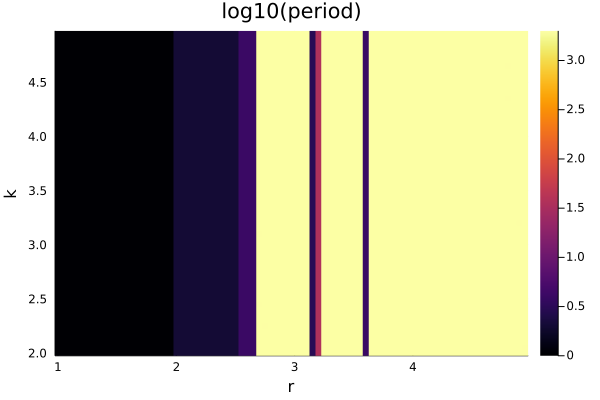

In [10]:
function calcperiod2d_threads(f; lentr = 2000, nskips = 50000, x0 = (0.4, 0.5),
        r = (1:0.05:5)[1:end-1], k = (2:0.05:5)[1:end-1], tol=1e-3
    )
    tr1 = [Vector{Float64}(undef, lentr+1) for _ in 1:nthreads()]
    tr2 = [Vector{Float64}(undef, lentr+1) for _ in 1:nthreads()]
    period = Matrix{Int}(undef, length(r), length(k))
    # prog = Progress(length(r)*length(k))
    @threads for j in eachindex(k)
        tid = threadid()
        for i in eachindex(r)
            @inbounds period[i, j] = calcperiod2d!(tr1[tid], tr2[tid], f, (r[i], k[j]), x0, lentr, nskips; tol)
            # next!(prog)
        end
    end
    period, r, k
end

period_th, r, k = @time calcperiod2d_threads(f); flush(stdout)
period_th, r, k = @time calcperiod2d_threads(f); flush(stdout)
period_th, r, k = @time calcperiod2d_threads(f); flush(stdout)
heatmap(r, k, log10.(period_th'); xlabel="r", ylabel="k", title="log10(period)")

In [11]:
period == period_th

true

In [12]:
period

80×60 Matrix{Int64}:
    1     1     1     1     1     1  …     1     1     1     1     1     1
    1     1     1     1     1     1        1     1     1     1     1     1
    1     1     1     1     1     1        1     1     1     1     1     1
    1     1     1     1     1     1        1     1     1     1     1     1
    1     1     1     1     1     1        1     1     1     1     1     1
    1     1     1     1     1     1  …     1     1     1     1     1     1
    1     1     1     1     1     1        1     1     1     1     1     1
    1     1     1     1     1     1        1     1     1     1     1     1
    1     1     1     1     1     1        1     1     1     1     1     1
    1     1     1     1     1     1        1     1     1     1     1     1
    1     1     1     1     1     1  …     1     1     1     1     1     1
    1     1     1     1     1     1        1     1     1     1     1     1
    1     1     1     1     1     1        1     1     1     1     1     1
    

In [13]:
@btime calcperiod2d_threads(f; lentr = 2000, nskips = 50000, x0 = (0.4, 0.5),
    r = (1:0.05:5)[1:end-1], k = (2:0.05:5)[1:end-1], tol=1e-3)

  2.910 s (110 allocations: 424.17 KiB)


([1 1 … 1 1; 1 1 … 1 1; … ; 2001 2000 … 1999 2001; 2001 1995 … 2001 2001], 1.0:0.05:4.95, 2.0:0.05:4.95)

In [14]:
@code_warntype calcperiod2d_threads(f; lentr = 2000, nskips = 50000, x0 = (0.4, 0.5),
    r = (1:0.05:5)[1:end-1], k = (2:0.05:5)[1:end-1], tol=1e-3)

Variables
  #unused#::Core.Const(var"#calcperiod2d_threads##kw"())
  @_2::NamedTuple{(:lentr, :nskips, :x0, :r, :k, :tol), Tuple{Int64, Int64, Tuple{Float64, Float64}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}, Float64}}
  @_3::Core.Const(calcperiod2d_threads)
  f::Core.Const(f)
  lentr::Int64
  nskips::Int64
  x0::Tuple{Float64, Float64}
  r::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}
  k::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}
  tol::Float64
  @_11::Int64
  @_12::Int64
  @_13::Tuple{Float64, Float64}
  @_14::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}
  @_15::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}
  @_16::Float64

Body::Tuple{Matrix{Int64}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwiceP